# Evolutionary Algorithms

This is the final project of the first block of the Evolutionary Algorithms subject of the Master in Software Engineering and Artificial Intelligence.

The project consists of experimenting with the ssGA algorithm and drawing conclusions. The problem we are going to try to solve is the Subset sum problem.

This project should have been done using the software [ssGA](https://neo.lcc.uma.es/software/ssga/description.php) written in Java. I am a full time worker and I do not really have time to do the experiments by hand so I wanted to automate everything, I do not know Java so I thought it would be faster to write the complete algorithm and the experiments in python than to learn Java enough to automate the experiments and the plots.

## 1 - Subset Sum Problem

Given a multiset of integers and a target sum T, does any subset of the numbers sum to precisely T? Subset sum can also be regarded as an optimization problem: find a subset whose sum is as close as possible to T. This last case is the one we are going to use here, we are going to try to get the subset which sum is the closes to a target T.

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Subset_sum_problem)

## 2 - Steady State Genetic Algorithm (ssGA)

This GA is steady state meaning that there are no generations. It differs from the generic GA in that each iteration it does not generate a complete generation, instead it generates just an individual and it is inserted in the population.

## 3 - Source Code

### 3.1 - Generic

In this section I will present my version of the ssGA. This version is adapted from the code written in Java found in the web of [neo](https://neo.lcc.uma.es/software/ssga/description.php) from the University of Malaga.

This section holds only the generic code applied to ssGA or event to every GA, the class specifications for the specific problem of the subset sum will be explained in the next section.

First some libraries that we will use need to be imported

In [1]:
import time
import copy

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt 
from tabulate import tabulate

The first part of the code is the population. It is an abstraction to group a group of individuals. It takes as arguments the number of individuals and a function able to generate them. The population is generated at instantiation time.

This class has some additional functionalities like the possibility of iterating through it, access to random positions in its internal array, get the size of the population or print it.

In [2]:
class Population:
    def __init__(self, size, individual_generator):
        self._population = [individual_generator() for i in range(size)]
            
    def __getitem__(self, indices):
        return self._population[indices]
    
    def __setitem__(self, indices, values):
        raise NotImplemented
    
    def __iter__(self):
        self._n = 0
        return self

    def __next__(self):
        if self._n < len(self._population):
            self._n += 1
            return self._population[self._n-1]
        else:
            raise StopIteration
    
    def __str__(self):
        return '\n'.join([str(i) for i in self._population])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self._population)

Next we have the definition of a problem. This is an abstract class that will have to be specialized to a defined problem, it acts like the definitions of an interface mainly.

It says that with a problem we will be able to get the phenotype of an individual, get its fitness value and count the number of evaluations.

In [3]:
class Problem:
    def __init__(self):
        self.evaluations = 0
    
    def evaluate(self, indiv):
        self.evaluations += 1
        return self._evaluate(indiv)
        
    def _evaluate(self, indiv):
        raise NotImplemented       
        
    def phenotype(self, indiv):
        raise NotImplemented  

The same for the class EvolutionaryAlgorithm. It just define an interface that has to be implemented later on in a subclass.

In [4]:
class EvolutionaryAlgorithm:
    def __init__(self, problem, config):
        self.config = config
        self.problem = problem
        self.population = None
        self._generate_population()
        self.iterations = 0
        
    def _generate_population(self):
        raise NotImplemented
        
    def selection(self):
        raise NotImplemented
    
    def combination(self):
        raise NotImplemented
    
    def mutation(self):
        raise NotImplemented
        
    def replacement(self):
        raise NotImplemented
        
    def is_terminated(self):
        raise NotImplemented
        
    def step(self):
        self.iterations += 1
        self._step()
        
    def run(self):
        raise NotImplemented
    
    def get_solution(self):
        raise NotImplemented
        
    def _step(self):
        raise NotImplemented

The class Experiment in another interface. This one will be useful to hold different experiences to reach a conclusion. For example, it could hold different executions with different population sizes.

In [5]:
class Experiment:
    def __init__(self):
        self.config = None
        self.problem = None
        self.algorithm = None
        self.results = None
        
    def setup_execution(self):
        raise NotImplemented
    
    def teardown_execution(self):
        raise NotImplemented
    
    def execution(self):
        raise NotImplemented
    
    def run(self):
        raise NotImplemented

### 3.2 - Specific for the Subset Sum Problem

In this section I will present the specialization of the previously explained interfaces and some other needed classes.

We are going to start choosing a representation for the individuals for this problem.

The chosen representation is an array of booleans (or '0's and '1's) of the same length as the set of integers availables for the problem. If, for example, in position 3 of our representation there is a 1, it means that the number in position 3 of the set of integers must be added, this number will be omitted otherwise (when we have a 0 in our representation).

I have kept the genotype and what we call the individual separated to keep the same structure than the original code.

The Chromosome is just an array of booleans randomly initialized and the Individual it is a class that holds a Chromosome and its fitness value.

In [6]:
class Chromosome:
    def __init__(self, length:int):
        self._alleles = np.random.rand(length) > 0.5
    
    @staticmethod
    def from_values(values):
        c = Chromosome(len(values))
        c.alleles = values
        return c
    
    @property
    def alleles(self):
        return self._alleles
        
    @alleles.setter
    def alleles(self, values):
        self._alleles = np.array(list(values), dtype=np.int).astype(np.bool)
        
    def __getitem__(self, indices):
        return self.alleles[indices]
    
    def __setitem__(self, indices, values):
        self.alleles[indices] = values
    
    def __str__(self):
        return ''.join(['1' if i else '0' for i in self.alleles])
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return self.alleles.size

In [7]:
class Individual:
    def __init__(self, length:int):
        self._chromosome = Chromosome(length)
        self._fitness = 0.0
    
    @staticmethod
    def get_factory(length):
        return lambda: Individual(length)
        
    @property
    def fitness(self):
        return self._fitness
        
    @fitness.setter
    def fitness(self, value:float):
        self._fitness = value
        
    @property
    def chromosome(self):
        return self._chromosome
        
    @chromosome.setter
    def chromosome(self, chrom):
        self._chromosome.alleles = Chromosome.from_values(chrom)
        
    def __eq__(self, other):
        return (self._chromosome.alleles == other.chromosome.alleles).all()
     
    def __lt__(self, other):
        return self.fitness < other.fitness
        
    def __le__(self, other):
        return self.fitness <= other.fitness
        
    def __gt__(self, other):
        return self.fitness > other.fitness
        
    def __ge__(self, other):
        return self.fitness >= other.fitness
        
    def __str__(self):
        return f'Chromosome: {self.chromosome}\nFitness: {self.fitness}'
    
    def __repr__(self):
        return self.__str__()
    
    def __len__(self):
        return len(self.chromosome)

The specialization for the problem is defined in this class, ProblemSubsetSum. Here we define the fitness function as the square value of the difference of the sum of the phenotype of an individual and the target value.

In [8]:
class ProblemSubsetSum(Problem):
    def __init__(self, numbers, target):
        self._numbers = np.array(numbers, dtype=np.int)
        self._target = int(target)
        super().__init__()
        
    def _evaluate(self, indiv):
#        return (np.sum(indiv.chromosome.alleles * self._numbers) - self._total)**2       
        return (np.sum(self.phenotype(indiv)) - self._target)**2       
        
    def phenotype(self, indiv):
        pheno = indiv.chromosome.alleles * self._numbers
        return pheno[pheno != 0]
    
    def __str__(self):
        return f'Numbers:\n {self._numbers}\nTarget: {self._target}'
    
    def __repr__(self):
        return self.__str__()

The specialization for EvolutionaryAlgorithm and Experiment are dependent of the experiment I run, so those will be explained in more detail in each experiment.

## 4 - Experiments

### 4.1 - Population size 

In this experiment I will vary the population size and we will study the effect in the found solutions and in the execution details.

The EvolutionaryAlgorithm specialization for this experiment is AlgoPopSize. Its characteristics in the different phases are:
- **Selection**: binary tournament.
- **Combination**: single point crossover.
- **Mutation**: random bit flip.
- **Replacement**: the worst individual is always replaced by the new one.
- **Termination**: after a maximum number of iterations or if the solution is found.

In [9]:
class AlgoPopSize(EvolutionaryAlgorithm):
    def __init__(self, problem, config):
        self._best_ever = None
        super().__init__(problem, config)
        self._aux = None
        
    def _generate_population(self):
        self.population = Population(self.config['population_size'], 
                                     Individual.get_factory(
                                         len(self.problem._numbers)))
        for i in self.population:
            i.fitness = self.problem.evaluate(i)
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))
        
    def selection(self):
        self._aux = (self._binary_tournament(), self._binary_tournament())
        return self._aux
    
    def combination(self):
        # no crossover
        if np.random.rand() > self.config['prob_crossover']:
            self._aux = np.random.choice(self._aux)
        else:
            self._aux = self._single_point_crossover(*self._aux)
        return self._aux
        
    def mutation(self):
        self._aux.chromosome = [not i if np.random.rand() < self.config['prob_mutation'] else i
                                for i in self._aux.chromosome]
        return self._aux
        
    def replacement(self):
        rep = max(self.population, key=lambda x: x.fitness)
        rep.chromosome = self._aux.chromosome
        rep.fitness = self.problem.evaluate(rep)
        self._aux = rep
        if rep.fitness < self._best_ever.fitness:
            self._best_ever = copy.deepcopy(rep)
        return self._aux
        
    def is_terminated(self):
        if self.iterations >= self.config['max_num_iterations']:
            print(f'Terminated: Max number of iterations reached with {self.iterations}')
            return True
        elif self._best_ever.fitness == 0:
            print(f'Terminated: Solution found')
            return True
        return False
        
    def _step(self):
        self.selection()
        self.combination()
        self.mutation()
        self.replacement()
        
    def run(self):
        while not self.is_terminated():
            self.step()
        return self.get_solution()
    
    def get_solution(self):
        return self._best_ever
        
    def _binary_tournament(self):
        i1 = np.random.randint(len(self.population))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self.population))
        return min(self.population[i1], self.population[i2])
    
    def _single_point_crossover(self, p1, p2):
        point = np.random.randint(len(p1))
        i = copy.deepcopy(p1)
        i.chromosome[:point] = p2.chromosome[:point] 
        return i

The experiment is defined here. It holds a configuration for the problem with the specific parameters like probabilities of different events, execution parameters, etc.

It also holds the exact definition of the problem with the real numbers. The problem is generated randomly when we instantiate the experiment. I have defined the problem like a set with 200 integers between -100 and 100 and the target a number between -5000 and 5000. With this setup probabilistically I will get 100 positive numbers and 100 negative numbers, the average of the positive ones will be around 50, 50*100=5000, so I would have a good probability of getting a problem that is solvable. The same is valid for the negative numbers.

The other properties of the experiment are:
- Number of executions for every experience = 30
- Probability of crossover = 0.70
- Probability of mutation = 0.05

And the **populations size** we will try are **5, 10, 50, 100, 500, 1000** individuals.

In [10]:
class ExpPopSize(Experiment):
    def __init__(self):
        super().__init__()
        # specific definition of the problem
        problem_set = (np.random.rand(200) * 200).astype(np.int) - 100
        problem_target = np.random.randint(10000) - 5000
        # configuration of the experiment
        self.config = {
            # config for the experiment
            'number_executions': 30,
            'change_rand_seed': True,
            # config for the algo
            'algorithm': AlgoPopSize,
            'population_size': [5, 10, 50, 100, 500, 1000],
            'prob_crossover': 0.7,
            'prob_mutation': 0.05,
            'max_num_iterations': 2000,
            # config of the problem
            'problem': ProblemSubsetSum,
            'problem_args': (problem_set, problem_target)
        }
        # save things to plot later
        self.results = {}
        self._results_execution = []
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
        self._time = None
        self._time_execution = None
        self._time_step = None
        # the seed used 
        self.random_seed = 0
        
    def setup_execution(self):
        # setup random seed
        np.random.seed(self.random_seed)
        if self.config['change_rand_seed']:
            self.random_seed += 1
        # create new problem and population
        self.problem = self.config['problem'](*self.config['problem_args'])
        self.algorithm = self.config['algorithm'](self.problem, self.config)
    
    def teardown_execution(self):
#        solution = self.problem.phenotype(self.algorithm.get_solution())
#        print('solution', solution)
#        print('sum(solution): ', sum(solution))
#        print('self.problem.evaluations: ', self.problem.evaluations)
#        print('--------------------------------------------------')
        pass
    
    def execution(self):
        while not self.algorithm.is_terminated():
            self._time_step = time.time()
            self.algorithm.step()
            self._time_step = time.time() - self._time_step
            self._save_results_step()
        
    def run(self):
        population_size = copy.deepcopy(self.config['population_size'])
        for pop_size in population_size:
            #print(f'Running experiment with population size: {pop_size}')
            self.config['population_size'] = pop_size
            self._time = time.time()
            for i in range(self.config['number_executions']):
                self.setup_execution()
                self._time_execution = time.time()
                self.execution()
                self._time_execution = time.time() - self._time_execution
                self.teardown_execution()
                self._save_results_execution()
            self._time = time.time() - self._time
            #print(f'Took {self._time} seconds.')
            self._save_results_experiment()
        self.config['population_size'] = population_size
            
    def get_problem(self):
        return self.config['problem'](*self.config['problem_args'])
    
    def _save_results_step(self):
        best = min(self.algorithm.population, key=lambda x: x.fitness)
        worst = max(self.algorithm.population, key=lambda x: x.fitness)
        best_ever = self.algorithm.get_solution()
        average_fitness = sum([i.fitness for i in self.algorithm.population])/len(self.algorithm.population)
        iteration = self.algorithm.iterations
        self._results_step['best'].append(copy.deepcopy(best))
        self._results_step['worst'].append(copy.deepcopy(worst))
        self._results_step['best_ever'].append(copy.deepcopy(best_ever))
        self._results_step['average_fitness'].append(average_fitness)
        self._results_step['iteration'].append(iteration)
        self._results_step['time'].append(self._time_step)
    
    def _save_results_execution(self):
        self._results_execution.append(copy.deepcopy(self._results_step))
        # to hold the results within the execution
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'time': []}
    
    def _save_results_experiment(self):
        self.results['pop_size_'+str(self.config['population_size'])] = copy.deepcopy(self._results_execution)
        self._results_execution = []

The experiment takes time to run so we want to save the results to use them later on, then if we turn off the computer or restart the kernel we can deserialize the results and continue from here.

In [11]:
%%time
import os
import pickle

f_name = '../data/experiment_population_size.pckl'

force_run = False

if not force_run and os.path.exists(f_name):
    # load the results
    with open(f_name, 'rb') as f:
        experiment_population_size = pickle.load(f)
else:
    # run the experiment
    experiment_population_size = ExpPopSize()
    print('-------------------  PROBLEM  -------------------')
    print(experiment_population_size.get_problem())
    print('-------------------------------------------------')
    experiment_population_size.run()
    # save results
    
    with open(f_name, 'wb') as f:
        pickle.dump(experiment_population_size, f)

        
results = experiment_population_size.results
config = experiment_population_size.config
problem = experiment_population_size.get_problem()

CPU times: user 7.78 s, sys: 684 ms, total: 8.47 s
Wall time: 10.6 s


From this point the results are in the variable *results* and this is what we are going to use to do the plots.

#### 4.1.1 - Fitness
The first thing to check is which experiment has reached the solution and how far the others are from the solution. 

Experience       Found sol(%)    Best fitness     Worst fitness    Average fitness    Std fitness
-------------  --------------  --------------  ----------------  -----------------  -------------
pop_size_5                  0          251001       2.97908e+06        1.76912e+06         716224
pop_size_10                 0          466489       1.62562e+06   897340                   291503
pop_size_50                 0           39601  600625             244506                   137933
pop_size_100                0           51076  512656             241764                   126075
pop_size_500                0          819025       1.88788e+06        1.29204e+06         242236
pop_size_1000               0          749956       2.59854e+06        1.84454e+06         413110


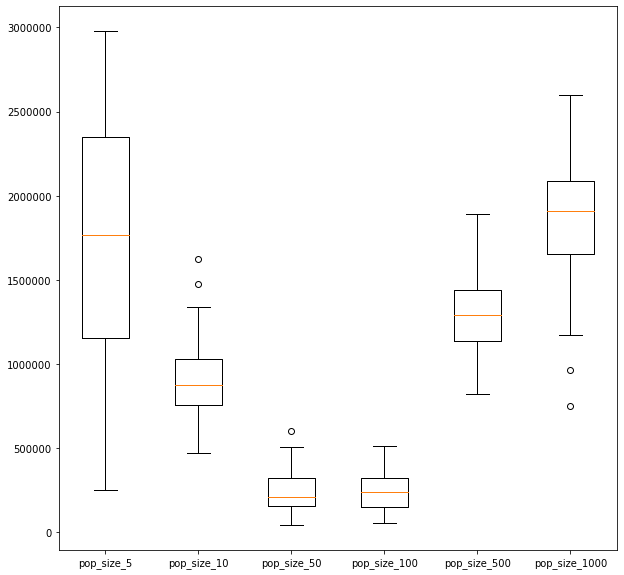

In [12]:
best = []
expe = []
for name, exp in results.items():
    solutions = [exe['best_ever'][-1].fitness for exe in exp]
    n_perfect_sols = sum([1 for i in solutions if i==0])
    best.append(solutions)
    expe.append([name, n_perfect_sols/len(solutions), min(solutions), max(solutions), np.average(solutions), np.std(solutions)])
print(tabulate(expe, headers=['Experience', 'Found sol(%)', 'Best fitness', 'Worst fitness', 'Average fitness', 'Std fitness']))

plt.figure(figsize=(10,10))
plt.boxplot(best, labels=results.keys())
plt.show()

From this small analysis we can see a few things just by eye:
- There are differences in the output when we change the population size.
- I would say that there is a correlation between the different population sizes and the performance of the algorithm.
- This correlation is not linear, small and big populations are bad, population sizes of 50 and 100 seem to perform much better than the others and they are more consistent.


We are going to do a statistical test to see if we can conclude that there are differences between the different experiences. Usually in this cases we would use ANOVA test, but as we saw in the boxplots the variances of the different experiments do not seem to be similar, that is why we will perform a Kruskal-Wallis test which is a non parametric version of the one-way ANOVA.

In [13]:
best = []
av = []
for name, exp in results.items():
    best.append([exe['best_ever'][-1].fitness for exe in exp])
    av.append([exe['average_fitness'][-1] for exe in exp])

print(f'The results for the Kruskal-Wallis test for the best individual fitness are {stats.kruskal(*best)}')
print()
print(f'The results for the Kruskal-Wallis test for the average fitness are {stats.kruskal(*av)}')


The results for the Kruskal-Wallis test for the best individual fitness are KruskalResult(statistic=140.68871766486004, pvalue=1.277227421626727e-28)

The results for the Kruskal-Wallis test for the average fitness are KruskalResult(statistic=162.66386740331484, pvalue=2.6775044078266735e-33)


The test proves what we had seen with the naked eye, the change in the size of the population affects the performance of the algorithm. As you can see the test shows that the different samples come from different distributions, so they are statistically different.


Now we are going to plot is the fitness of the best individual in each iteration for each experiment

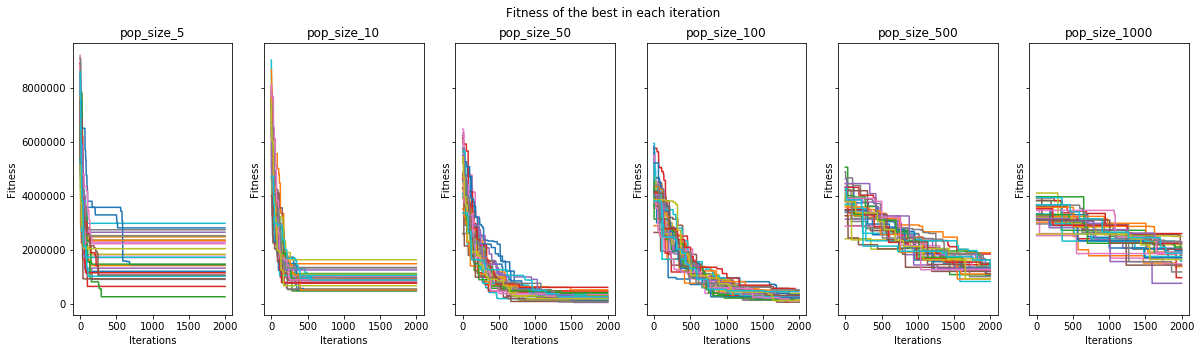

In [14]:
# the fitness of the best in each step for each exp
fig, axs = plt.subplots(1, len(results), figsize=(20, 5), sharex=True, sharey=True)
for n, exp in enumerate(results.keys()):
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best']]
        _ax, = axs[n].plot(fitness)
    axs[n].set_title(exp)
    axs[n].set_xlabel('Iterations')
    axs[n].set_ylabel('Fitness')
fig.suptitle('Fitness of the best in each iteration')
plt.show() 

We can see that
- With bigger population size, using a random initialization, the possibility of having some good solutions at the beginning is bigger.
- With a smaller population it looks like their convergence is faster.
- With a very smaller population (5 individuals) it looks like it does not always converge to a good solution.

Let's make zoom in the first 100 iterations and the last 500.

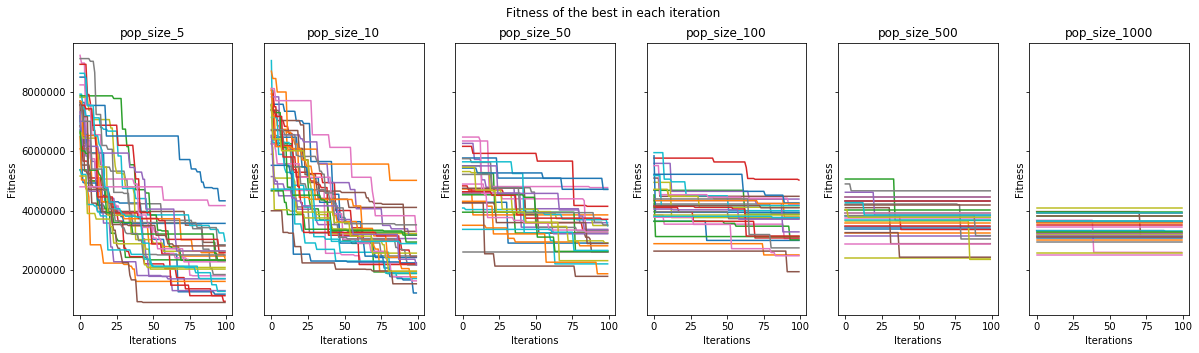

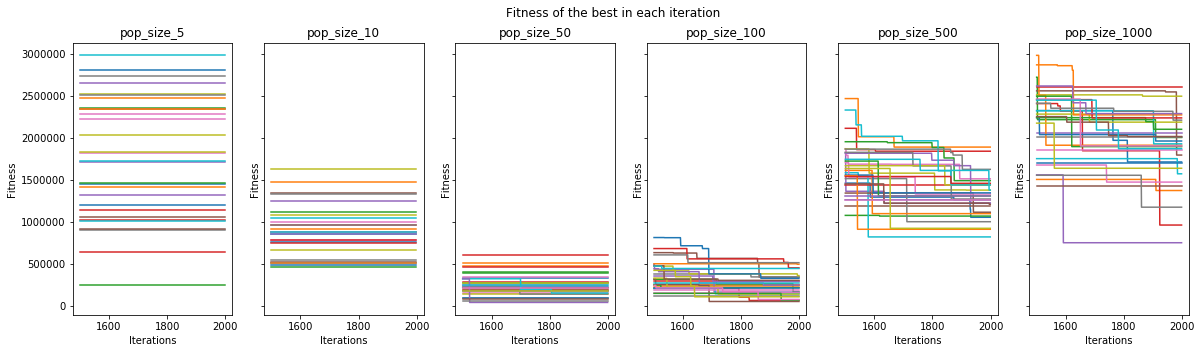

In [15]:
fig, axs = plt.subplots(1, len(results), figsize=(20, 5), sharex=True, sharey=True)
for n, exp in enumerate(results.keys()):
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best'][:100]]
        _ax, = axs[n].plot(fitness)
    axs[n].set_title(exp)
    axs[n].set_xlabel('Iterations')
    axs[n].set_ylabel('Fitness')
fig.suptitle('Fitness of the best in each iteration')
plt.show() 

fig, axs = plt.subplots(1, len(results), figsize=(20, 5), sharex=True, sharey=True)
for n, exp in enumerate(results.keys()):
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best'][1500:]]
        _ax, = axs[n].plot(range(1500, 2000),fitness)
    axs[n].set_title(exp)
    axs[n].set_xlabel('Iterations')
    axs[n].set_ylabel('Fitness')
fig.suptitle('Fitness of the best in each iteration')
plt.show() 

With a smaller population the improvements in the solution are very big at the beginning while with a big population it is difficult to improve the initial solutions. We can see as well that in general the solutions with population size of 50 and 100 have better performance at the end.

Now we are going to average all the executions of every experience an plt them in the same graph to get a global understanding.

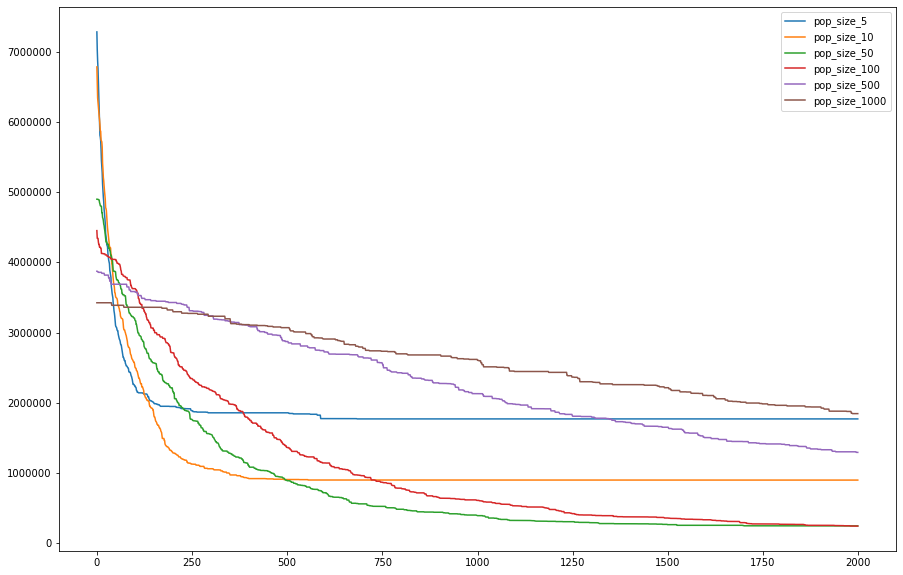

In [16]:
plt.figure(figsize=(15,10))
axs = []
for n, exp in enumerate(results.keys()):
    fitness_total = []
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best']]
        fitness_total.append(fitness)
    fitness_total = np.array(fitness_total)
    ax, = plt.plot(np.average(fitness_total, axis=0))
    axs.append(ax)
plt.legend(axs, results.keys())
plt.show()

From here I would say that the populations with a big number of individuals do not converge after 2000  iterations and as we said before, it looks like the best population size for this problem are 50 and 100 individuals, they converge fast and at the end they get a good solution.


The last analysis we are going to do is to plot the fitness(best, average, worst) vs the population.


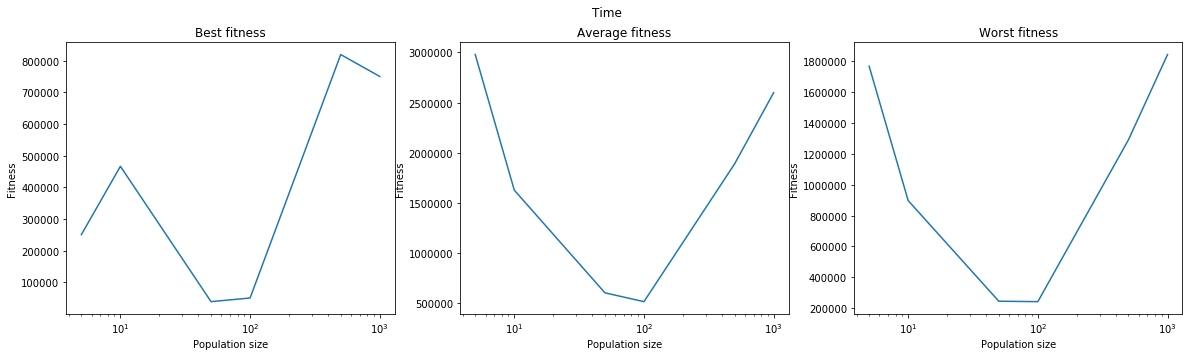

In [17]:
titles = ['Best fitness', 'Average fitness', 'Worst fitness']
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for i in range(3):
    axs[i].plot(config['population_size'], [e[i+2] for e in expe])
    axs[i].set_xscale('log')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population size')
    axs[i].set_ylabel('Fitness')
fig.suptitle('Time')
plt.show() 

It is clear that there is a zone in the middle that gets the best solutions. A very small or a very big population takes us to bad solutions. The best population sizes look like to be 100 individuals so far.

#### 4.1.2 - Time
Now lets study the time every step takes and study the influence of the population size.

In [18]:
expe = []
for name, exp in results.items():
    ts = []
    for exe in exp:
        ts.extend(exe['time'])
    expe.append([name, min(ts), max(ts), np.average(ts), np.std(ts)])
print(tabulate(expe, headers=['Experience', 'Best time', 'Worst time', 'Average time', 'Std time']))

Experience       Best time    Worst time    Average time     Std time
-------------  -----------  ------------  --------------  -----------
pop_size_5     0.000719309    0.00463533     0.000813422  0.000104504
pop_size_10    0.000715971    0.0051322      0.00081761   0.000116063
pop_size_50    0.00074172     0.00832796     0.000876983  0.00016847
pop_size_100   0.000748396    0.00320959     0.000865292  0.00010593
pop_size_500   0.0009799      0.00529909     0.00110302   0.000123097
pop_size_1000  0.00123763     1.09073        0.00144068   0.00445139


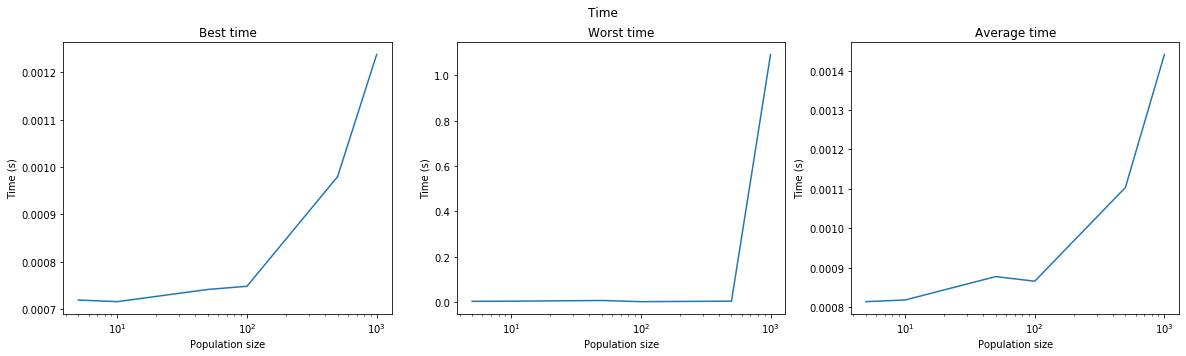

In [19]:
titles = ['Best time', 'Worst time', 'Average time']
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for i in range(3):
    axs[i].plot(config['population_size'], [e[i+1] for e in expe])
    axs[i].set_xscale('log')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population size')
    axs[i].set_ylabel('Time (s)')
fig.suptitle('Time')
plt.show() 

The biggest is our population, the longer it will take to do each step. That doesn't make sense for me because there is only random access to the population in each step which should be the same in all the lengths, the only thing that may take more time is the search of the worst individual to be replaced. I could benchmark that part of the code and study it in detail but I will keep the global view of the problem.

### 4.2 - Local search

In this experiment I will add a local search in the algorithm. After the mutation I will choose a random allele, I will flip its value and I will keep the best of both individuals, the original or the output of the after.

I will study the performance of the algorithm depending on the numbers of steps I do in the search.

The EvolutionaryAlgorithm specialization for this experiment is AlgoSearch. Its characteristics in the different phases are:
- **Selection**: binary tournament.
- **Combination**: single point crossover.
- **Mutation**: random bit flip.
- **Replacement**: the worst individual is always replaced by the new one.
- **Termination**: after a maximum number of evaluations or if the solution is found.

I would like to emphasize that the termination criteria is the number of evaluations and not the number of iterations like before.

In [20]:
class AlgoSearch(EvolutionaryAlgorithm):
    def __init__(self, problem, config):
        self._best_ever = None
        super().__init__(problem, config)
        self._aux = None
        
    def _generate_population(self):
        self.population = Population(self.config['population_size'], 
                                     Individual.get_factory(
                                         len(self.problem._numbers)))
        for i in self.population:
            i.fitness = self.problem.evaluate(i)
        self._best_ever = copy.deepcopy(
            min(self.population, key=lambda x: x.fitness))
        
    def selection(self):
        self._aux = (self._binary_tournament(), self._binary_tournament())
        return self._aux
    
    def combination(self):
        # no crossover
        if np.random.rand() > self.config['prob_crossover']:
            self._aux = np.random.choice(self._aux)
        else:
            self._aux = self._single_point_crossover(*self._aux)
        return self._aux
        
    def mutation(self):
        self._aux.chromosome = [not i if np.random.rand() < self.config['prob_mutation'] else i
                                for i in self._aux.chromosome]
        return self._aux
    
    def search(self):
        for i in range(self.config['search_steps']):
            ind = np.random.randint(len(self._aux.chromosome))
            self._aux.chromosome[ind] = not self._aux.chromosome[ind]
            new_fitness = self.problem.evaluate(self._aux)
            if new_fitness > self._aux.fitness:
                # if its worse roll back
                self._aux.chromosome[ind] = not self._aux.chromosome[ind]
            else:
                # if its better update the fitness
                self._aux.fitness = new_fitness
        return self._aux
        
    def replacement(self):
        rep = max(self.population, key=lambda x: x.fitness)
        rep.chromosome = self._aux.chromosome
        rep.fitness = self.problem.evaluate(rep)
        self._aux = rep
        if rep.fitness < self._best_ever.fitness:
            self._best_ever = copy.deepcopy(rep)
        return self._aux
        
    def is_terminated(self):
        if self.problem.evaluations >= self.config['max_num_evaluations']:
            print(f'Terminated: Max number of evaluations reached with {self.problem.evaluations}')
            return True
        elif self._best_ever.fitness == 0:
            print(f'Terminated: Solution found')
            return True
        return False
        
    def _step(self):
        self.selection()
        self.combination()
        self.mutation()
        self.search()
        self.replacement()
        
    def run(self):
        while not self.is_terminated():
            self.step()
        return self.get_solution()
    
    def get_solution(self):
        return self._best_ever
        
    def _binary_tournament(self):
        i1 = np.random.randint(len(self.population))
        i2 = i1
        while i1 == i2:
            i2 = np.random.randint(len(self.population))
        return min(self.population[i1], self.population[i2])
    
    def _single_point_crossover(self, p1, p2):
        point = np.random.randint(len(p1))
        i = copy.deepcopy(p1)
        i.chromosome[:point] = p2.chromosome[:point] 
        return i

The problem in this case is exactly the same than the one in the previous experiment.

The other properties of the experiment are:
- Number of executions for every experience = 30
- Probability of crossover = 0.70
- Probability of mutation = 0.05
- Population size = 100 (the best one from the previous experiment)
- Max number of evaluations = 5000

And the **number of search steps** performed we will try are **1, 2, 5, 10**.

In [21]:
class ExpSearchSteps(Experiment):
    def __init__(self):
        super().__init__()
        # specific definition of the problem
        problem_set = (np.random.rand(200) * 200).astype(np.int) - 100
        problem_target = np.random.randint(10000) - 5000
        # configuration of the experiment
        self.config = {
            # config for the experiment
            'number_executions': 30,
            'change_rand_seed': True,
            # config for the algo
            'algorithm': AlgoSearch,
            'population_size': 100,
            'prob_crossover': 0.7,
            'prob_mutation': 0.05,
            'max_num_evaluations': 5000,
            'search_steps': [1, 2, 5, 10],
            # config of the problem
            'problem': ProblemSubsetSum,
            'problem_args': (problem_set, problem_target)
        }
        # save things to plot later
        self.results = {}
        self._results_execution = []
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'evaluations': [],
                        'time': []}
        self._time = None
        self._time_execution = None
        self._time_step = None
        # the seed used 
        self.random_seed = 0
        
    def setup_execution(self):
        # setup random seed
        np.random.seed(self.random_seed)
        if self.config['change_rand_seed']:
            self.random_seed += 1
        # create new problem and population
        self.problem = self.config['problem'](*self.config['problem_args'])
        self.algorithm = self.config['algorithm'](self.problem, self.config)
    
    def teardown_execution(self):
#        solution = self.problem.phenotype(self.algorithm.get_solution())
#        print('solution', solution)
#        print('sum(solution): ', sum(solution))
#        print('self.problem.evaluations: ', self.problem.evaluations)
#        print('--------------------------------------------------')
        pass
    
    def execution(self):
        while not self.algorithm.is_terminated():
            self._time_step = time.time()
            self.algorithm.step()
            self._time_step = time.time() - self._time_step
            self._save_results_step()
        
    def run(self):
        search_steps = copy.deepcopy(self.config['search_steps'])
        for search_step in search_steps:
            self.config['search_steps'] = search_step
            self._time = time.time()
            for i in range(self.config['number_executions']):
                self.setup_execution()
                self._time_execution = time.time()
                self.execution()
                self._time_execution = time.time() - self._time_execution
                self.teardown_execution()
                self._save_results_execution()
            self._time = time.time() - self._time
            self._save_results_experiment()
        self.config['search_steps'] = search_steps
            
    def get_problem(self):
        return self.config['problem'](*self.config['problem_args'])
    
    def _save_results_step(self):
        best = min(self.algorithm.population, key=lambda x: x.fitness)
        worst = max(self.algorithm.population, key=lambda x: x.fitness)
        best_ever = self.algorithm.get_solution()
        average_fitness = sum([i.fitness for i in self.algorithm.population])/len(self.algorithm.population)
        iteration = self.algorithm.iterations
        evaluations = self.problem.evaluations
        self._results_step['best'].append(copy.deepcopy(best))
        self._results_step['worst'].append(copy.deepcopy(worst))
        self._results_step['best_ever'].append(copy.deepcopy(best_ever))
        self._results_step['average_fitness'].append(average_fitness)
        self._results_step['iteration'].append(iteration)
        self._results_step['evaluations'].append(iteration)
        self._results_step['time'].append(self._time_step)
    
    def _save_results_execution(self):
        self._results_execution.append(copy.deepcopy(self._results_step))
        # to hold the results within the execution
        self._results_step = {'best': [],
                        'worst': [],
                        'best_ever': [],
                        'average_fitness': [],
                        'iteration': [],
                        'evaluations': [],
                        'time': []}
    
    def _save_results_experiment(self):
        self.results['search_steps_'+str(self.config['search_steps'])] = copy.deepcopy(self._results_execution)
        self._results_execution = []

Like before, we are going to save the results to use them later.

In [22]:
%%time
import os
import pickle

f_name = '../data/experiment_search_steps.pckl'

force_run = False

if not force_run and os.path.exists(f_name):
    # load the results
    with open(f_name, 'rb') as f:
        experiment_search_steps = pickle.load(f)
else:
    # run the experiment
    experiment_search_steps = ExpSearchSteps()
    print('-------------------  PROBLEM  -------------------')
    print(experiment_search_steps.get_problem())
    print('-------------------------------------------------')
    experiment_search_steps.run()
    # save results
    
    with open(f_name, 'wb') as f:
        pickle.dump(experiment_search_steps, f)

        
results = experiment_search_steps.results
config = experiment_search_steps.config
problem = experiment_search_steps.get_problem()

CPU times: user 3.37 s, sys: 87.9 ms, total: 3.45 s
Wall time: 4.45 s


Again we will use the variable *results* to hold our results and analyse them.

#### 4.2.1 - Fitness
The first thing to check is which experiment has reached the solution and how far the others are from it.

Experience         Found sol(%)    Best fitness    Worst fitness    Average fitness    Std fitness
---------------  --------------  --------------  ---------------  -----------------  -------------
search_steps_1                0          543169      2.00789e+06        1.14666e+06         362381
search_steps_2                0          831744      2.1609e+06         1.2822e+06          321519
search_steps_5                0          662596      2.28917e+06        1.54198e+06         373899
search_steps_10               0          817216      2.244e+06          1.64917e+06         347341


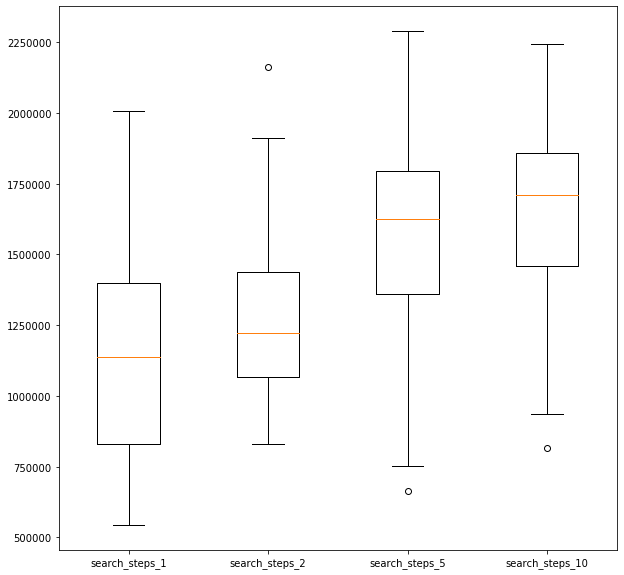

In [23]:
best = []
expe = []
for name, exp in results.items():
    solutions = [exe['best_ever'][-1].fitness for exe in exp]
    n_perfect_sols = sum([1 for i in solutions if i==0])
    best.append(solutions)
    expe.append([name, n_perfect_sols/len(solutions), min(solutions), max(solutions), np.average(solutions), np.std(solutions)])
print(tabulate(expe, headers=['Experience', 'Found sol(%)', 'Best fitness', 'Worst fitness', 'Average fitness', 'Std fitness']))

plt.figure(figsize=(10,10))
plt.boxplot(best, labels=results.keys())
plt.show()

In this case we cannot say that much from this analysis. It looks like there is a linear relationship between the number of search steps and the performance of the algorithm.

We will use again the Kruskal-Wallis test to see if we have statistical differences between the different experiences.

In [24]:
best = []
av = []
for name, exp in results.items():
    best.append([exe['best_ever'][-1].fitness for exe in exp])
    av.append([exe['average_fitness'][-1] for exe in exp])

print(f'The results for the Kruskal-Wallis test for the best individual fitness are {stats.kruskal(*best)}')
print()
print(f'The results for the Kruskal-Wallis test for the average fitness are {stats.kruskal(*av)}')


The results for the Kruskal-Wallis test for the best individual fitness are KruskalResult(statistic=30.392294834709045, pvalue=1.1412003142457883e-06)

The results for the Kruskal-Wallis test for the average fitness are KruskalResult(statistic=91.2112947658402, pvalue=1.2032859402438608e-19)


As you can see, the test shows that the different samples come from different distributions, so they are statistically different. This shows that the number of steps in the search affect the performance of the algorithm.


Now we are going to plot is the fitness of the best individual in each iteration for each experiment

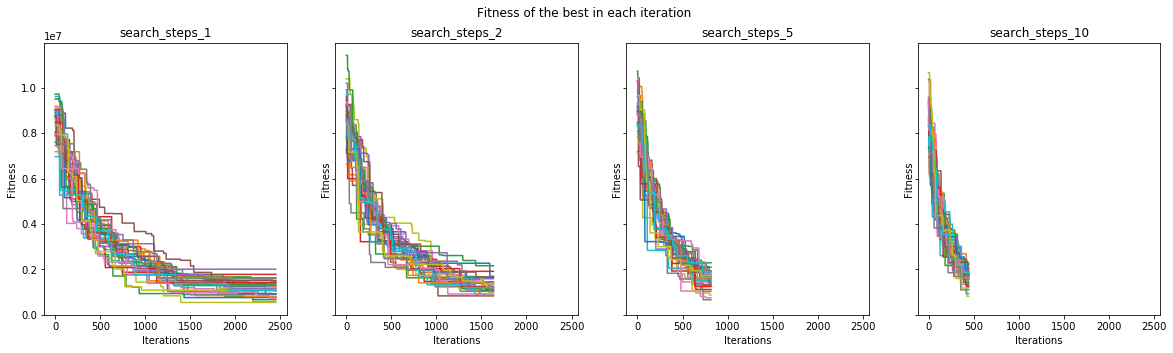

In [25]:
# the fitness of the best in each step for each exp
fig, axs = plt.subplots(1, len(results), figsize=(20, 5), sharex=True, sharey=True)
for n, exp in enumerate(results.keys()):
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best']]
        _ax, = axs[n].plot(fitness)
    axs[n].set_title(exp)
    axs[n].set_xlabel('Iterations')
    axs[n].set_ylabel('Fitness')
fig.suptitle('Fitness of the best in each iteration')
plt.show() 

The conclusions from those:
- Obviously with the same number of evaluations, with less steps in the search we can have more iterations.
- With a smaller population it looks like we get slightly better final solutions.

Let's zoom in the first 1000 iterations.

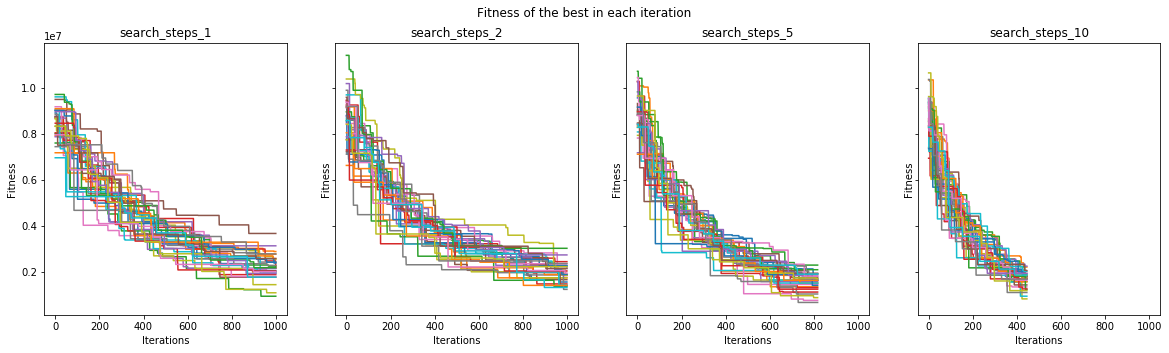

In [26]:
fig, axs = plt.subplots(1, len(results), figsize=(20, 5), sharex=True, sharey=True)
for n, exp in enumerate(results.keys()):
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best'][:1000]]
        _ax, = axs[n].plot(fitness)
    axs[n].set_title(exp)
    axs[n].set_xlabel('Iterations')
    axs[n].set_ylabel('Fitness')
fig.suptitle('Fitness of the best in each iteration')
plt.show() 

At this point I think this is not very useful, I cannot see a big difference between them.

Now we are going to average all the executions of every experience and plot them in the same graph to get a global understanding.

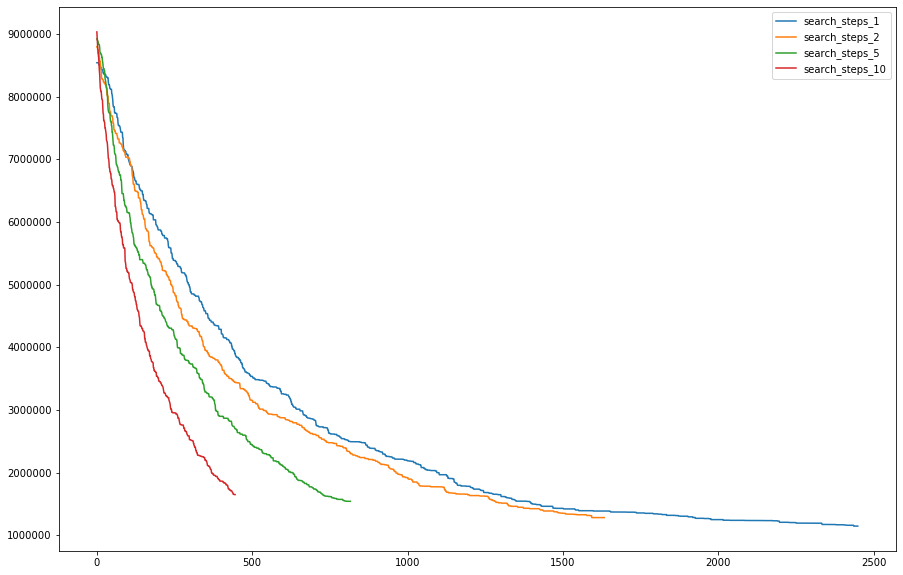

In [27]:
plt.figure(figsize=(15,10))
axs = []
for n, exp in enumerate(results.keys()):
    fitness_total = []
    for exe in results[exp]:
        fitness = [b.fitness for b in exe['best']]
        fitness_total.append(fitness)
    fitness_total = np.array(fitness_total)
    ax, = plt.plot(np.average(fitness_total, axis=0))
    axs.append(ax)
plt.legend(axs, results.keys())
plt.show()

In this experiment we have kept the resources (evaluations of the fitness function) the same for all the experiences and we can see that with less number of steps in the local search we get better performance. The trend for the search_steps_10 is quite aggressive when the experiments finish, that may indicate that it has room to improve the solution. If I increase the number of evaluations allowed probably it will reach the same performance as the others.


The last analysis we are going to do is to plot the fitness(best, average, worst) vs the search steps.

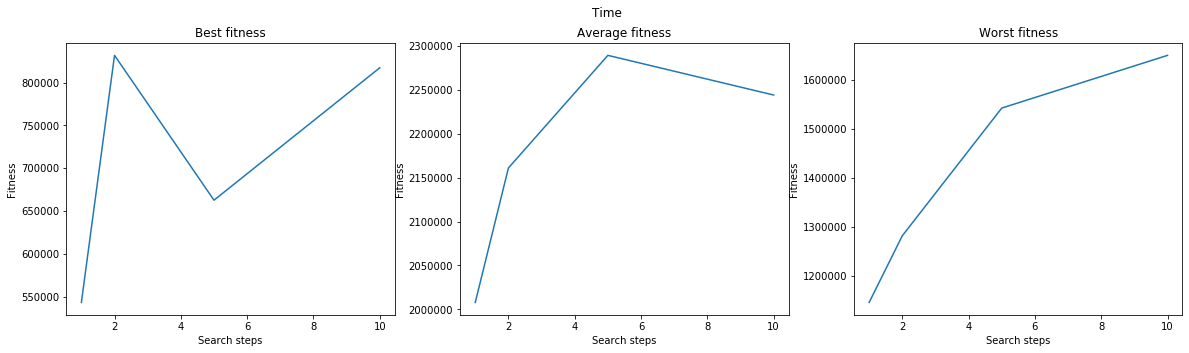

In [28]:
titles = ['Best fitness', 'Average fitness', 'Worst fitness']
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for i in range(3):
    axs[i].plot(config['search_steps'], [e[i+2] for e in expe])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Search steps')
    axs[i].set_ylabel('Fitness')
fig.suptitle('Time')
plt.show() 

There is a clear difference in the final solution for the different experiences. That is probably because the resources are limited and I think the local search with more steps has room to improve its solution but what we are looking for here is a trade off between resources and a better solution. I would say that with this kind of local search to have just one step is the best.

#### 4.2.2 - Time
Now lets study the time every step takes and study the influence of the number of steps in the local search.

In [29]:
expe = []
for name, exp in results.items():
    ts = []
    for exe in exp:
        ts.extend(exe['time'])
    expe.append([name, min(ts), max(ts), np.average(ts), np.std(ts)])
print(tabulate(expe, headers=['Experience', 'Best time', 'Worst time', 'Average time', 'Std time']))

Experience         Best time    Worst time    Average time     Std time
---------------  -----------  ------------  --------------  -----------
search_steps_1   0.000769615    0.0117488      0.000885509  0.000121763
search_steps_2   0.000813961    0.00621128     0.000933081  0.000129345
search_steps_5   0.000879049    0.00430369     0.00098544   9.98293e-05
search_steps_10  0.0010283      0.00399065     0.00112899   0.000113228


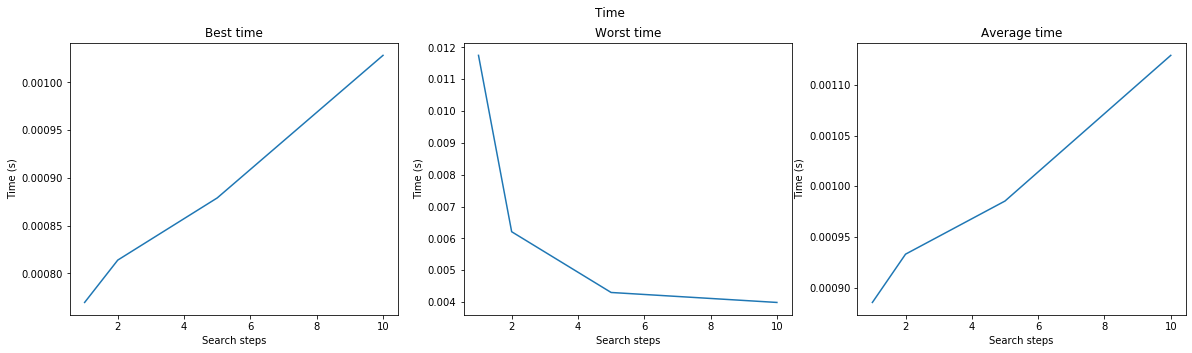

In [30]:
titles = ['Best time', 'Worst time', 'Average time']
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)
for i in range(3):
    axs[i].plot(config['search_steps'], [e[i+1] for e in expe])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Search steps')
    axs[i].set_ylabel('Time (s)')
fig.suptitle('Time')
plt.show() 

It is logical and we can see there is a linear dependence between the number of steps in the local search and the time each step of the EA takes.

Now we are going to take a look at the overall time.

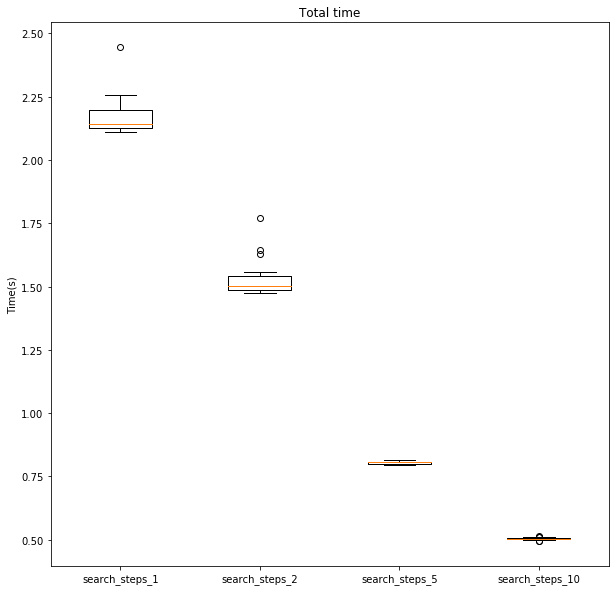

In [31]:
expe = []
for name, exp in results.items():
    ts = []
    for exe in exp:
        ts.append(sum(exe['time']))
    expe.append(ts)

plt.figure(figsize=(10,10))
plt.boxplot(expe, labels=results.keys())
plt.title('Total time')
plt.ylabel('Time(s)')
plt.show()

This diagram shows that even when the steps take much longer, the total time is much smaller with more steps in the local search. With this final conclusion, if I am designing an algorithm to solve this problem, maybe I would choose a local search with more steps and allow more evaluations because we could multiply by 4 the number of evaluations with 10 steps per search to get the same total time than with one step per search.